Как водится в продакшен-реди решениях на тензорфлоу надо перезапустить среду каждый раз после установки нового пакета - это не ошибка.

In [1]:
#!pip install --upgrade numpy tensorflow

## **Load the required libraries**

In [2]:
#!pip install sionna

In [3]:
# You may install the required libraries from https://nvlabs.github.io/sionna/installation.html
# or generate channel here in google colab
# ---------------------------------------------------------------------------------------------
# Load the required libraries
import numpy as np
import matplotlib.pyplot as plt

try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna
# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
from sionna.phy.channel.tr38901 import Antenna, AntennaArray, UMa, UMi, RMa
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, gen_single_sector_topology
from sionna.phy.ofdm import ResourceGrid

## **Configiration parameters**

In [4]:
# ===========================
# 1️⃣ Define BS & UE Parameters
# ===========================
num_bs = 1  # Number of Base Stations
num_ue = 20  # Number of User Equipments   уменьшила до 20
num_ue_ant = 4  # UE MIMO Antennas
batch_size = 4  # Number of parallel simulations   уменьшила до 4
scenario = "UMa"  # Urban Macro (Can be "UMa", "UMi", "RMa")
min_bs_ut_dist = 100 # Minimum BS-UE distance in meters
ISD = 500 # Inter-Site Distance
bs_height = 25 # BS height in meters
ut_height = 1.5 # UE height in meters
UE_speed = 0.83 # UE speed in meters/second

# ===========================
# 2️⃣ Define Resource Grid
# ===========================
carrier_frequency = 3.5e9  # 2.14 or 3.5 GHz (mid-band 5G)
fft_size = 256  # FFT Size   уменьшила до 256
sc_spacing = 30e3  # Subcarrier Spacing (30 kHz for FR1)
num_ofdm_symbols = 1  # OFDM symbols per slot

# ===========================
# 3️⃣ Define Antenna Array Configurations
# ===========================
bs_array = AntennaArray(
    num_rows=4, # number of rows in BS antenna array
    num_cols=8, # number of columns in BS antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=0.9, # 0.9-wavelength spacing between vertical antenna elements
    horizontal_spacing=0.5 # Half-wavelength spacing between horizontal antenna elements
)

ue_array = AntennaArray(
    num_rows=1, # number of rows in UE antenna array
    num_cols=2, # number of columns in UE antenna array
    polarization="dual", # "single" or "dual"
    polarization_type="cross", # for single polarization, must be "V" or "H". For dual polarization, must be "VH" or "cross"
    antenna_pattern="38.901", # "omni" or "38.901"
    carrier_frequency=carrier_frequency,
    vertical_spacing=1, # One-wavelength spacing between vertical antenna elements
    horizontal_spacing=1  # One-wavelength spacing between horizontal antenna elements
)

# ===========================
# 4️⃣ Select Channel Model
# ===========================
if scenario == "UMa":
  channel_model = UMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "UMi":
  channel_model = UMi(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")
elif scenario == "RMa":
  channel_model = RMa(carrier_frequency=carrier_frequency,
                      o2i_model= "low",
                      ut_array=ue_array,
                      bs_array=bs_array,
                      direction="downlink")

# ===========================
# 5️⃣ Set 3GPP Scenario Parameters
# ===========================
pre_topology = sionna.phy.channel.set_3gpp_scenario_parameters(
                      scenario=scenario.lower(),
                      min_bs_ut_dist=min_bs_ut_dist,  # Minimum BS-UE distance in meters
                      isd=ISD,  # Inter-Site Distance
                      bs_height=bs_height,  # BS height in meters
                      min_ut_height=ut_height,  # Minimum UE height in meters
                      max_ut_height=ut_height,  # Maximum UE height in meters
                      indoor_probability=0, # Probability of a UE to be indoor
                      min_ut_velocity=UE_speed, # ! meter/sec
                      max_ut_velocity=UE_speed)

min_bs_ut_dist, isd, bs_height, min_ut_height, max_ut_height, indoor_probability, min_ut_velocity, max_ut_velocity = pre_topology

## **Channel generation**

-----------------------------------------------------
Size of output frequency domain channel tensor:
 batch_size = 4 
 UE number = 20 
 UE antenna number = 4 
 BS number = 1 
 BS antenna number = 64 
 number ofdm symbols = 1 
 Subcarriers number = 256
*********** Successful channel generation ***********


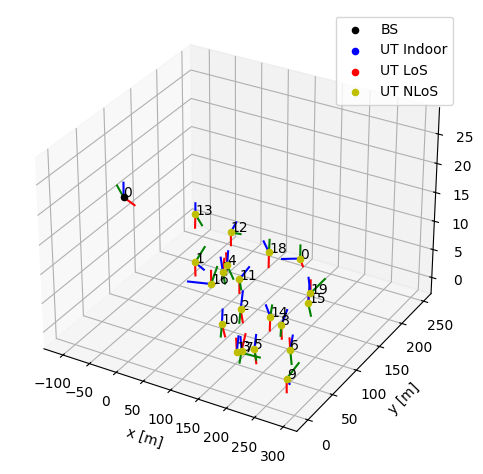

In [5]:
# ===========================
# 6️⃣ Generate Single Sector Topology
# ===========================
topology = gen_single_sector_topology(
                      batch_size=batch_size,
                      num_ut=num_ue,
                      isd=isd,
                      min_bs_ut_dist=min_bs_ut_dist,
                      scenario=scenario.lower(),
                      min_ut_height=min_ut_height,
                      max_ut_height=max_ut_height,
                      indoor_probability=indoor_probability,
                      min_ut_velocity=min_ut_velocity,
                      max_ut_velocity=max_ut_velocity)

ut_loc, bs_loc, ut_orientations, bs_orientations, ut_velocities, in_state = topology

# ===========================
# 7️⃣ Set Topology into the Channel Model
# ===========================
channel_model.set_topology(
    ut_loc,
    bs_loc,
    ut_orientations,
    bs_orientations,
    ut_velocities,
    in_state,
    los = False)# los=False=NLoS, los=True=LoS, None=LoS

channel_model.show_topology()

# ===========================
# 8️⃣ Simulate Time-Domain Channel
# ===========================
a, tau = channel_model(num_time_samples=num_ofdm_symbols,sampling_frequency=sc_spacing)  # Get channel impulse response (CIR)

# ===========================
# 9️⃣ Move Channel from Time to Frequency Domain
# ===========================
subcarrier_freqs = subcarrier_frequencies(fft_size, sc_spacing)
H_freq = cir_to_ofdm_channel(subcarrier_freqs, a, tau, normalize=True)  # Convert CIR to OFDM channel

print("-----------------------------------------------------")
print(f"Size of output frequency domain channel tensor:\n batch_size = {H_freq.shape[0]} \n UE number = {H_freq.shape[1]} \n UE antenna number = {H_freq.shape[2]} \n BS number = {H_freq.shape[3]} \n BS antenna number = {H_freq.shape[4]} \n number ofdm symbols = {H_freq.shape[5]} \n Subcarriers number = {H_freq.shape[6]}")
print("*********** Successful channel generation ***********")

# ===========================
# ✅ Output Results
# ===========================
H_freq = np.transpose(np.squeeze(H_freq),(3,2,4,1,0)) # Output channel tensor H=[N_tx x N_rx x N_sc x N_ue x N_batch]

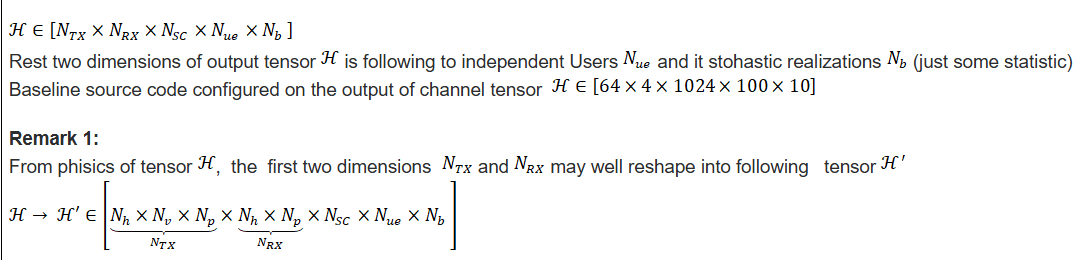

## **Save the channel tensor to '.mat' or '.npy' file**

In [6]:
# from scipy.io import savemat
# savemat(f"Sionna_3GPP_{scenario.upper()}_Channel.mat", {'Hfrq': H_freq})
# from google.colab import files
# files.download(f"Sionna_3GPP_{scenario.upper()}_Channel.mat") # uncomment this to download the tensor

N_tx (BS antenna number) - Количество антенн на Базовой Станции, 32 после Такера

N_rx (UE antenna number) - Количество антенн на Пользовательском Устройстве, 4

N_subcarriers (Subcarriers number) - Количество поднесущих, 128 после Такера

N_users (UE number) - Количество пользователей, 20

N_batches (batch_size) - Количество батчей, 4

каждое число имеет вид H[i,j,k,l,m] = a + bj = |H| * e^(jφ),где

|H| (амплитуда) - ослабление сигнала на этой поднесущей

φ (фаза) - фазовый сдвиг сигнала

i - какая антенна BS передает

j - какая антенна UE принимает

k - на какой поднесущей частоте

l - для какого пользователя

m - в какой реализации канала

In [7]:
#pip install torchcfm --upgrade


In [8]:
#pip install "scipy==1.10.1"

In [9]:
import scipy, ot
print('SciPy:', scipy.__version__); print('POT:', ot.__version__)

SciPy: 1.10.1
POT: 0.9.0


In [10]:
# Normalization

import numpy as np

N_tx, N_rx, N_sc, N_users, N_batches = H_freq.shape
print("H_freq shape:", H_freq.shape)

def amplitude_phase_normalization(H_freq):#если нужен Такер то заменяем здесь и еще в нескольких местах здесь на H_freq_tucker
    """
    Нормализация по амплитуде и фазе (не по действительной/мнимой части)
    """
    # Извлекаем амплитуду и фазу
    amplitude = np.abs(H_freq)
    phase = np.angle(H_freq)

    # Логарифмируем амплитуду (обычно имеет log-normal распределение)
    log_amplitude = amplitude#если не логарифмировать
    #log_amplitude = np.log(amplitude + 1e-12)#если лографмировать

    # Нормализуем амплитуду и фазу отдельно
    amp_mean, amp_std = log_amplitude.mean(), log_amplitude.std()
    phase_mean, phase_std = phase.mean(), phase.std()

    log_amp_norm = (log_amplitude - amp_mean) / amp_std
    phase_norm = (phase - phase_mean) / phase_std

    # Сохраняем статистики для денормализации
    stats = {
        'amp_mean': amp_mean, 'amp_std': amp_std,
        'phase_mean': phase_mean, 'phase_std': phase_std
    }

    # Объединяем в один тензор [amplitude, phase]
    H_normalized = np.stack([log_amp_norm, phase_norm], axis=-1)

    return H_normalized, stats

def amplitude_phase_denormalize(H_normalized, stats):
    """
    Обратная нормализация амплитуды и фазы
    """
    log_amp_norm = H_normalized[..., 0]
    phase_norm = H_normalized[..., 1]

    # Денормализуем
    log_amplitude = log_amp_norm * stats['amp_std'] + stats['amp_mean']
    amplitude = np.exp(log_amplitude)
    phase = phase_norm * stats['phase_std'] + stats['phase_mean']

    # Преобразуем обратно в комплексные числа
    return amplitude * np.exp(1j * phase)


# Normalize H_freq
H_normalized, norm_stats = amplitude_phase_normalization(H_freq) # H_normalized: (N_tx, N_rx, N_sc, N_users, N_batches, 2)

# Reorder to [batch, users, BS, UE, SC, 2] -> merge batches and users
H_flat = H_normalized.transpose(4, 3, 0, 1, 2, 5)  # (N_batches, N_users, N_tx, N_rx, N_sc, 2)
H_flat = H_flat.reshape(-1, N_tx, N_rx, N_sc, 2)   # (N_samples, N_tx, N_rx, N_sc, 2)

data_normalized = H_flat.astype(np.float32)
print(f"Normalized (amp/phase) data range: [{data_normalized.min():.3f}, {data_normalized.max():.3f}]")

H_freq shape: (64, 4, 256, 20, 4)
Normalized (amp/phase) data range: [-1.983, 5.682]


In [11]:
import torch.nn as nn

class TimeCondUnet3D(nn.Module):
    def __init__(self, in_channels=2, base_dim=64):
        super().__init__()
        c_in = in_channels + 1  # +1 for time t

        self.net = nn.Sequential(
            nn.Conv3d(c_in, base_dim, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim, base_dim*2, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*2, base_dim*4, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*4, base_dim*4, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*4, base_dim*2, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim*2, base_dim, 3, padding=1), nn.ReLU(),
            nn.Conv3d(base_dim, base_dim, 3, padding=1), nn.ReLU(),

            nn.Conv3d(base_dim, in_channels, 3, padding=1)
        )

    def forward(self, x, t):
        # x: [B, 2, D, H, W]; t: [B] in [0,1]
        B, C, D, H, W = x.shape
        if t.ndim == 1:
            t = t[:, None]
        t_map = t.view(B, 1, 1, 1, 1).expand(B, 1, D, H, W)
        x_in = torch.cat([x, t_map], dim=1)
        return self.net(x_in)

class SimpleChannelUNet(nn.Module):
    def __init__(self, in_channels=2, base_dim=32):
        super().__init__()
        self.base_dim = base_dim
        # Time embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, base_dim),
            nn.SiLU(),
            nn.Linear(base_dim, base_dim)
        )

        # Простая архитектура с down/up sampling
        self.down1 = nn.Sequential(
            nn.Conv3d(in_channels + base_dim, base_dim, 3, padding=1),
            nn.GroupNorm(4, base_dim),
            nn.SiLU()
        )

        self.down2 = nn.Sequential(
            nn.Conv3d(base_dim, base_dim*2, 3, stride=2, padding=1),
            nn.GroupNorm(8, base_dim*2),
            nn.SiLU()
        )

        self.middle = nn.Sequential(
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1),
            nn.GroupNorm(8, base_dim*2),
            nn.SiLU(),
            nn.Conv3d(base_dim*2, base_dim*2, 3, padding=1),
            nn.GroupNorm(8, base_dim*2),
            nn.SiLU()
        )

        self.up1 = nn.Sequential(
            nn.ConvTranspose3d(base_dim*2, base_dim, 3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(4, base_dim),
            nn.SiLU()
        )

        self.final = nn.Sequential(
            nn.Conv3d(base_dim*2, base_dim, 3, padding=1),
            nn.GroupNorm(4, base_dim),
            nn.SiLU(),
            nn.Conv3d(base_dim, in_channels, 3, padding=1)
        )

    def forward(self, x, timesteps):
        # Time embedding
        t_embed = self.time_embed(timesteps.float().unsqueeze(-1))
        t_embed = t_embed.view(-1, self.base_dim, 1, 1, 1)
        t_embed = t_embed.expand(-1, -1, x.shape[2], x.shape[3], x.shape[4])

        # Concatenate with input
        x = torch.cat([x, t_embed], dim=1)

        # Downsample
        x1 = self.down1(x)
        x2 = self.down2(x1)

        # Middle
        x_mid = self.middle(x2)

        # Upsample
        x_up = self.up1(x_mid)

        # Skip connection and final
        x_out = torch.cat([x_up, x1], dim=1)
        return self.final(x_out)
    

In [12]:
# Dataloader

from torch.utils.data import DataLoader, TensorDataset
import torch

# To 3D-conv layout
data_tensor = torch.from_numpy(data_normalized)         # (N, N_tx, N_rx, N_sc, 2)
data_tensor = data_tensor.permute(0, 4, 3, 1, 2)       # (N, 2, N_sc, N_tx, N_rx)

dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

print(f"DataLoader ready with {len(dataloader)} batches; tensor shape={data_tensor.shape}")

DataLoader ready with 10 batches; tensor shape=torch.Size([80, 2, 256, 64, 4])


In [14]:
# SB-CFM training

import torch
import torch.nn as nn
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

# model = TimeCondUnet3D(in_channels=2, base_dim=64).to(device)
model = SimpleChannelUNet(in_channels=2, base_dim=32).to(device)

try:
    from torchcfm.conditional_flow_matching import SchrodingerBridgeConditionalFlowMatcher
except Exception:
    from torchcfm.losses import SchrodingerBridgeConditionalFlowMatcher

cfm = SchrodingerBridgeConditionalFlowMatcher(sigma=0.5, ot_method="exact")
opt = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

def _cfm_call_and_reshape(cfm, x0, x1, t):
    """
    x0, x1: [B, 2, D, H, W]
    Returns: xt, ut with same shape
    """
    B = x1.shape[0]
    x0_flat = x0.view(B, -1)
    x1_flat = x1.view(B, -1)

    try:
        out = cfm.sample_location_and_conditional_flow(x0_flat, x1_flat, t)
    except AttributeError:
        out = cfm(x0_flat, x1_flat, t)

    if isinstance(out, dict):
        xt_flat = out.get("xt", None)
        ut_flat = out.get("ut", None)
        if xt_flat is None or ut_flat is None:
            candidates = [v for v in out.values()
                          if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
            xt_flat, ut_flat = candidates[0], candidates[1]
    else:
        seq = list(out) if isinstance(out, (tuple, list)) else [out]
        candidates = [v for v in seq
                      if torch.is_tensor(v) and v.dim() == 2 and v.shape[0] == B]
        xt_flat, ut_flat = candidates[0], candidates[1]

    xt = xt_flat.view_as(x1)
    ut = ut_flat.view_as(x1)
    return xt, ut

num_epochs = 100
model.train()
for epoch in range(num_epochs):
    total = 0.0
    for (x1_batch,) in tqdm(dataloader, desc=f"SB-CFM epoch {epoch+1}/{num_epochs}"):
        x1 = x1_batch.to(device)                     # [B, 2, D, H, W]
        x0 = torch.randn_like(x1)                    # noise
        t  = torch.rand(x1.size(0), device=device)   # [B], U(0,1)

        xt, ut = _cfm_call_and_reshape(cfm, x0, x1, t)
        xt, ut = xt.to(device), ut.to(device)

        pred = model(xt, t)
        loss = nn.functional.mse_loss(pred, ut)

        opt.zero_grad()
        loss.backward()
        opt.step()
        total += loss.item()

    print(f"Epoch {epoch+1}: loss={total/len(dataloader):.6f}")

Device: cuda


SB-CFM epoch 1/100: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


Epoch 1: loss=2.735918


SB-CFM epoch 2/100: 100%|██████████| 10/10 [00:00<00:00, 11.76it/s]


Epoch 2: loss=2.691826


SB-CFM epoch 3/100: 100%|██████████| 10/10 [00:00<00:00, 11.87it/s]


Epoch 3: loss=1.833983


SB-CFM epoch 4/100: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


Epoch 4: loss=2.048561


SB-CFM epoch 5/100: 100%|██████████| 10/10 [00:00<00:00, 11.83it/s]


Epoch 5: loss=2.123905


SB-CFM epoch 6/100: 100%|██████████| 10/10 [00:00<00:00, 11.79it/s]


Epoch 6: loss=1.735016


SB-CFM epoch 7/100: 100%|██████████| 10/10 [00:00<00:00, 11.80it/s]


Epoch 7: loss=1.714857


SB-CFM epoch 8/100: 100%|██████████| 10/10 [00:00<00:00, 11.82it/s]


Epoch 8: loss=1.564167


SB-CFM epoch 9/100: 100%|██████████| 10/10 [00:00<00:00, 11.65it/s]


Epoch 9: loss=1.870982


SB-CFM epoch 10/100: 100%|██████████| 10/10 [00:00<00:00, 11.58it/s]


Epoch 10: loss=2.526449


SB-CFM epoch 11/100: 100%|██████████| 10/10 [00:00<00:00, 11.73it/s]


Epoch 11: loss=2.185321


SB-CFM epoch 12/100: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s]


Epoch 12: loss=1.964820


SB-CFM epoch 13/100: 100%|██████████| 10/10 [00:00<00:00, 11.78it/s]


Epoch 13: loss=1.451418


SB-CFM epoch 14/100: 100%|██████████| 10/10 [00:00<00:00, 11.64it/s]


Epoch 14: loss=1.738415


SB-CFM epoch 15/100: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


Epoch 15: loss=3.135316


SB-CFM epoch 16/100: 100%|██████████| 10/10 [00:00<00:00, 11.59it/s]


Epoch 16: loss=1.978765


SB-CFM epoch 17/100: 100%|██████████| 10/10 [00:00<00:00, 11.72it/s]


Epoch 17: loss=2.484140


SB-CFM epoch 18/100: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


Epoch 18: loss=2.717853


SB-CFM epoch 19/100: 100%|██████████| 10/10 [00:00<00:00, 11.68it/s]


Epoch 19: loss=1.680035


SB-CFM epoch 20/100: 100%|██████████| 10/10 [00:00<00:00, 11.81it/s]


Epoch 20: loss=2.157835


SB-CFM epoch 21/100: 100%|██████████| 10/10 [00:00<00:00, 11.75it/s]


Epoch 21: loss=1.639060


SB-CFM epoch 22/100: 100%|██████████| 10/10 [00:00<00:00, 11.80it/s]


Epoch 22: loss=1.643511


SB-CFM epoch 23/100:  80%|████████  | 8/10 [00:00<00:00, 10.42it/s]


KeyboardInterrupt: 

In [15]:
# Sampling SB-SDE & inverse normalization (amp/phase -> complex)

import numpy as np

@torch.no_grad()
def sample_sb_sde(model, num_samples=10, steps=40, shape=(2, 1, 1, 1),
                  sde_sigma=0.2, schedule="const", device='cpu'):
    """
      x_{k+1} = x_k + dt * v_theta(x_k, t_k) + g(t_k) * sqrt(dt) * N(0,I)
    shape = (2, D, H, W)
    """
    model.eval()
    x = torch.randn((num_samples,) + shape, device=device)
    dt = 1.0 / steps

    def g_of_t(t_scalar):
        if schedule == "const":
            return sde_sigma
        elif schedule == "vp":
            return sde_sigma * float(np.cos(0.5*np.pi*float(t_scalar)))
        else:
            return sde_sigma

    for k in range(steps):
        t = torch.full((num_samples,), (k + 0.5) / steps, device=device)
        v = model(x, t)
        g = g_of_t((k + 0.5) / steps)
        x = x + dt * v + (g * np.sqrt(dt)) * torch.randn_like(x)
    return x  # [N, 2, D, H, W]

# (D,H,W) = (N_sc,N_tx,N_rx)
_, _, D_shp, H_shp, W_shp = data_tensor.shape
gen_2c = sample_sb_sde(model, num_samples=10, steps=40,
                       shape=(2, D_shp, H_shp, W_shp),
                       sde_sigma=0.2, device=device)

def inverse_amp_phase_to_complex(samples_2c, stats):
    """
    samples_2c: torch.Tensor [N, 2, N_sc, N_tx, N_rx] (normalized amp/phase)
    -> complex np.ndarray [N, N_tx, N_rx, N_sc]
    """
    x = samples_2c.detach().cpu().numpy()                   # [N, 2, D, H, W]
    x = x.transpose(0, 2, 3, 4, 1)                          # [N, D, H, W, 2]
    x = x.transpose(0, 2, 3, 1, 4)                          # [N, H, W, D, 2]
    complex_denorm = amplitude_phase_denormalize(x, stats)  # [N, H, W, D]
    return complex_denorm

generated_complex = inverse_amp_phase_to_complex(gen_2c, norm_stats)  # [N, N_tx, N_rx, N_sc]

orig_2c_subset = data_tensor[:generated_complex.shape[0]]            # torch [N, 2, D, H, W]
def to_complex_from_norm(t2c_norm, stats):
    x = t2c_norm.detach().cpu().numpy()               # [N, 2, D, H, W]
    x = x.transpose(0, 2, 3, 4, 1)                    # [N, D, H, W, 2]
    x = x.transpose(0, 2, 3, 1, 4)                    # [N, H, W, D, 2]
    return amplitude_phase_denormalize(x, stats)

original_complex = to_complex_from_norm(orig_2c_subset, norm_stats)  # [N, N_tx, N_rx, N_sc]

In [18]:
# Metrics in normalized space: sliced wasserstein, and moments matching

import numpy as np
import torch
import ot
from ot.sliced import sliced_wasserstein_distance

def _flatten_amp_phase_2c(arr_2c, max_points=200000, seed=0):
    """
    arr_2c: [N, 2, D, H, W] (normalized amp/phase)
    Returns [M, 2] samples.
    """
    if isinstance(arr_2c, torch.Tensor):
        arr = arr_2c.detach().cpu().numpy()
    else:
        arr = arr_2c
    # [N, 2, D, H, W] -> [N, D, H, W, 2] -> [N*D*H*W, 2]
    arr = np.moveaxis(arr, 1, -1)
    pts = arr.reshape(-1, 2)

    M = min(max_points, pts.shape[0])
    idx = np.random.choice(pts.shape[0], size=M, replace=False)
    return pts[idx].astype(np.float64)

orig_norm_2c = orig_2c_subset   # torch [N, 2, D, H, W] normalized amp/phase
gen_norm_2c  = gen_2c           # torch [N, 2, D, H, W] normalized amp/phase

X = _flatten_amp_phase_2c(orig_norm_2c, max_points=200000, seed=0)  # [M,2]
Y = _flatten_amp_phase_2c(gen_norm_2c,  max_points=200000, seed=1)  # [M,2]

swd = sliced_wasserstein_distance(X, Y, n_projections=128, p=1, seed=42)
print(f"Sliced Wasserstein (amp/phase, normalized, W1): {swd:.6f}")

# Generated (normalized) stats
gen_np = gen_norm_2c.detach().cpu().numpy()   # [N, 2, D, H, W]
gen_amp   = gen_np[:, 0, ...]
gen_phase = gen_np[:, 1, ...]

print("mean(generated_phase)", float(gen_phase.mean()))
print("std(generated_phase)",  float(gen_phase.std()))
print("mean(generated_amplitude)", float(gen_amp.mean()))
print("std(generated_amplitude)",  float(gen_amp.std()))

# Reference (normalized) stats
H_flat_amplitude = H_flat[..., 0]
H_flat_phase     = H_flat[..., 1]

print("mean(H_flat_phase)", float(H_flat_phase.mean()))
print("std(H_flat_phase)",  float(H_flat_phase.std()))
print("mean(H_flat_amplitude)", float(H_flat_amplitude.mean()))
print("std(H_flat_amplitude)",  float(H_flat_amplitude.std()))

Sliced Wasserstein: 0.088802
mean(generated_phase) 0.006290393881499767
std(generated_phase) 0.9624173641204834
mean(generated_amplitude) 0.06561330705881119
std(generated_amplitude) 0.9988273978233337
mean(H_flat_phase) -1.9121216610074043e-08
std(H_flat_phase) 1.0000001192092896
mean(H_flat_amplitude) -5.360692512113019e-07
std(H_flat_amplitude) 1.000000238418579


In [ ]:
# Save

import torch

save_path = 'channel_sbcfm_amp_phase.pth'
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': opt.state_dict(),
    'norm_stats': norm_stats,               # amplitude/phase stats
    'shape': (2, N_sc, N_tx, N_rx)         # for future sampling
}, save_path)
print("Saved to:", save_path)

# Load
ckpt = torch.load(save_path, map_location='cpu')
model.load_state_dict(ckpt['model_state_dict'])
norm_stats = ckpt['norm_stats']
print("Loaded model and norm_stats.")